# Data preparation and analysis


## Imports

In [1]:
# Imports
%matplotlib inline
import gzip
import shutil
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from mapping_gff3 import MappingGff3
import xml.etree.ElementTree as et
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import random
from sklearn.datasets import make_checkerboard
from sklearn.cluster import SpectralBiclustering, SpectralClustering, OPTICS, cluster_optics_dbscan
from sklearn.metrics import consensus_score
import itertools
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets._samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS
from scipy.stats import kstest
from scipy.stats import lognorm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


## Load data


### Load gene vs. sample data

In [2]:
IntVeld2022_data_path = 'Data/IntVeld2022'
file_in = f"{IntVeld2022_data_path}/TEP_Count_Matrix.tsv.gz"
file_out = f"{IntVeld2022_data_path}/TEP_Count_Matrix.tsv"

with gzip.open(file_in, 'rb') as f_in:
    with open(file_out, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
data_df = pd.read_csv(file_out, sep='\t')
print(data_df.shape)
data_df.head(5)

(5440, 2351)


,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,11-Vumc-HD-149-TR932,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
ENSG00000000419,5,79,58,128,93,12,0,0,18,28,...,3,0,1,2,9,16,22,21,0,1
ENSG00000000460,8,10,21,14,6,8,25,42,5,7,...,0,3,0,2,63,3,3,0,1,0
ENSG00000000938,24,336,334,59,120,22,31,13,19,36,...,8,45,1,7,163,90,46,75,14,8
ENSG00000001036,38,46,15,36,25,43,27,27,59,5,...,1,3,4,15,3,6,10,8,3,0
ENSG00000001461,72,17,11,9,18,28,5,6,49,18,...,1,1,0,0,12,2,6,6,1,0


In [4]:
data_df.describe()

,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,11-Vumc-HD-149-TR932,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
count,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,...,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000
mean,416.658088,306.222059,200.325551,195.664706,237.270037,334.639706,341.358272,252.479228,394.240809,245.939706,...,8.734191,20.176471,10.531985,68.953676,72.238235,45.864338,60.372794,58.598346,26.045956,12.340257
std,3066.455618,1793.920257,952.352515,1038.835194,1730.393051,3177.352322,3628.050653,2653.946262,3450.241199,2257.938852,...,42.144076,95.671902,61.385799,632.827481,240.796406,167.926359,279.658516,280.009581,159.463452,69.402550
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,38.000000,28.000000,15.000000,16.000000,10.000000,9.000000,7.000000,12.000000,10.000000,...,1.000000,2.000000,1.000000,0.000000,13.000000,7.000000,7.000000,7.000000,2.000000,0.000000
50%,46.000000,79.000000,57.000000,40.000000,39.000000,32.000000,32.000000,23.000000,37.000000,30.000000,...,2.000000,6.000000,2.000000,7.000000,30.000000,16.000000,17.000000,16.000000,6.000000,2.000000
75%,155.000000,175.250000,127.250000,106.000000,106.000000,113.000000,105.000000,82.000000,131.000000,92.000000,...,6.000000,14.000000,6.000000,25.000000,63.000000,36.000000,43.000000,39.000000,15.000000,7.000000
max,145767.000000,84007.000000,34436.000000,34350.000000,67053.000000,170113.000000,203036.000000,121701.000000,149776.000000,117896.000000,...,1942.000000,3794.000000,2481.000000,27572.000000,9134.000000,6704.000000,14273.000000,10810.000000,6394.000000,2576.000000


In [5]:
# Count missing values
data_df.isna().sum().sum()

0

In [6]:
# Count equal values 0 (0 number of genes in the sample)
data_df.isin([0]).sum(axis=1).sum()

1134949

### TPM normalization.
References:

https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/

https://support.bioconductor.org/p/9146002/

Uses the MappingGff3 utility class to calculate the length of each gene according to the Human comprehensive gene annotation GFF3
(https://www.gencodegenes.org/human/release_19.html)

#### 1. Calculate the size of each gene

In [7]:
# Set the following variable for the different types of gene size calculation. The possible values are: 'mean', 'max' or 'min'
length_type = 'max'

gff3_path = "Data/ComprehensiveGeneAnnotation"
m_gff3 = MappingGff3(f"{gff3_path}/gencode.v19.annotation.gff3.gz")
gene_length_method = ['max', 'min','mean']
for method in gene_length_method:
    file_name = f"{gff3_path}/genes_length_{method}.csv"
    if not os.path.exists(file_name):
        m_gff3.generate_gff3_db()
        length_file = [(x, m_gff3.get_length_gene_kb(x, method=method)) for x in data_df.index.tolist()]
        pd.DataFrame(length_file).to_csv(file_name, index=False, header =['Gene_name', f"length_{method}"])

In [8]:
gene_length = pd.read_csv(f"{gff3_path}/genes_length_{length_type}.csv", sep=',')

In [9]:
gene_length.head(5)

,Gene_name,length_max
0,ENSG00000000419,1.151
1,ENSG00000000460,4.331
2,ENSG00000000938,2.716
3,ENSG00000001036,2.349
4,ENSG00000001461,5.468


#### 2. Normalize for gene length. Divide the read counts by the length of each gene in kilobases. This gives you reads per kilobase (RPK).

In [10]:
df_genes_normalized = data_df.div(gene_length[f"length_{length_type}"].tolist(), axis = 0)
df_genes_normalized.head(5)

,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,11-Vumc-HD-149-TR932,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
ENSG00000000419,4.344049,68.635969,50.390964,111.207646,80.799305,10.425717,0.000000,0.000000,15.638575,24.326672,...,2.606429,0.000000,0.868810,1.737619,7.819288,13.900956,19.113814,18.245004,0.000000,0.868810
ENSG00000000460,1.847148,2.308936,4.848765,3.232510,1.385361,1.847148,5.772339,9.697529,1.154468,1.616255,...,0.000000,0.692681,0.000000,0.461787,14.546294,0.692681,0.692681,0.000000,0.230894,0.000000
ENSG00000000938,8.836524,123.711340,122.974963,21.723122,44.182622,8.100147,11.413844,4.786451,6.995582,13.254786,...,2.945508,16.568483,0.368189,2.577320,60.014728,33.136966,16.936672,27.614138,5.154639,2.945508
ENSG00000001036,16.177097,19.582801,6.385696,15.325670,10.642827,18.305662,11.494253,11.494253,25.117071,2.128565,...,0.425713,1.277139,1.702852,6.385696,1.277139,2.554278,4.257131,3.405705,1.277139,0.000000
ENSG00000001461,13.167520,3.108998,2.011704,1.645940,3.291880,5.120702,0.914411,1.097293,8.961229,3.291880,...,0.182882,0.182882,0.000000,0.000000,2.194587,0.365764,1.097293,1.097293,0.182882,0.000000


#### 3. Normalize for sequencing depth. Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.

In [11]:
# x / (x.sum()/ scaling_factor) = (x*scaling_factor)/x.sum()
df_genes_normalized = df_genes_normalized.transform(lambda x: (x*10**6)/x.sum())
df_genes_normalized.head(5)

,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,11-Vumc-HD-149-TR932,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
ENSG00000000419,4.095057,76.170510,92.725472,173.743823,99.233270,10.460905,0.000000,0.000000,13.673941,33.805396,...,108.844833,0.000000,30.302673,7.984921,46.834429,116.900018,124.796011,118.553809,0.000000,21.781520
ENSG00000000460,1.741274,2.562400,8.922314,5.050270,1.701425,1.853383,5.520069,11.889019,1.009435,2.246018,...,0.000000,12.144979,0.000000,2.122061,87.126528,5.825095,4.522582,0.000000,3.000107,0.000000
ENSG00000000938,8.330033,137.291803,226.288814,33.938838,54.262670,8.127486,10.915022,5.868113,6.116745,18.419424,...,123.004813,290.500209,12.841818,11.843614,359.464396,278.665153,110.581229,179.433298,66.976625,73.845447
ENSG00000001036,15.249858,21.732511,11.750453,23.943863,13.070935,18.367445,10.991917,14.091774,21.961678,2.957946,...,17.777835,22.392467,59.392723,29.344330,7.649557,21.480192,27.795234,22.129852,16.594464,0.000000
ENSG00000001461,12.412785,3.450289,3.701780,2.571513,4.042906,5.137985,0.874448,1.345264,7.835453,4.574539,...,7.637186,3.206529,0.000000,0.000000,13.144703,3.075894,7.164338,7.130078,2.376274,0.000000


In [12]:
# Count missing values
df_genes_normalized.isna().sum().sum()

0

In [13]:
# Count equal values 0 (0 number of genes normalized in the sample)
df_genes_normalized.isin([0]).sum(axis=1).sum()

1134949

In [14]:
df_genes_normalized.describe()

,1-Vumc-HD-101-TR922,2-Vumc-HD-103-TR923,3-Vumc-HD-108-TR924,4-Vumc-HD-127-TR925,5-Vumc-HD-130-TR926,6-Vumc-HD-142-TR927,7-Vumc-HD-143-TR928,8-Vumc-HD-144-TR929,9-Vumc-HD-145-TR930,11-Vumc-HD-149-TR932,...,countMatrix.3502-NKI-4854-SARC-TR3080,countMatrix.3503-NKI-4707-SARC-TR3079,countMatrix.3504-NKI-4941-SARC-TR3084,countMatrix.3507-NKI-6348-SARC-TR3134,countMatrix.3508-NKI-5275-SARC-TR3099,countMatrix.3512-NKI-5148-SARC-TR3129,countMatrix.320-10,countMatrix.327-34,countMatrix.376-P-PH-001-013-TR1400,countMatrix.506-NKI-NSCLC-107-270
count,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,...,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000
mean,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529,...,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529,183.823529
std,2225.672715,1714.374324,1443.983223,1471.553817,1985.420361,2704.156126,2921.734411,3143.498211,2483.268787,2687.615540,...,1477.566267,1703.344322,1999.304950,2866.284491,989.872203,907.721878,1300.232758,1520.600443,2110.378295,2024.842170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.905467,9.892089,12.850691,5.824526,4.402930,2.425565,2.224363,2.127199,2.688132,3.655445,...,7.856849,9.369208,6.057772,0.000000,20.267633,14.700309,11.212895,11.989397,6.310955,0.000000
50%,12.569094,25.900696,31.515115,17.802774,13.933404,9.046933,8.897151,8.169015,9.135503,12.094655,...,29.140065,29.300848,24.601219,8.835459,51.115725,39.675944,32.781947,28.969700,22.237191,14.401456
75%,47.282246,70.903064,82.004554,57.038784,48.144050,38.870114,34.813277,34.052549,39.369296,43.312324,...,85.420900,84.509028,72.225897,39.374415,124.851997,105.504623,92.000071,83.925453,66.275077,56.764005
max,120105.900255,85066.155332,70118.431429,67099.303400,101644.530618,148868.734274,160234.777206,191239.777440,131327.815521,147731.567897,...,68446.736750,93428.856696,121535.467616,177952.557944,44249.033915,32949.885950,54465.137403,78366.962127,116685.697616,90704.611436


In [15]:
df_genes_normalized_t = df_genes_normalized.transpose()
df_genes_normalized_t.head(5)

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000267279,ENSG00000267316,ENSG00000268555,ENSG00000269028,ENSG00000270055,ENSG00000271043,ENSG00000272053,ENSG00000272168,ENSG00000272369,ENSG00000272888
1-Vumc-HD-101-TR922,4.095057,1.741274,8.330033,15.249858,12.412785,1.815643,6.687894,5.566237,41.660991,28.708953,...,144.630669,432.783907,197.995292,833.519642,25.271901,317.563736,899.540795,10.779548,61.433211,26.599380
2-Vumc-HD-103-TR923,76.170510,2.562400,137.291803,21.732511,3.450289,8.549888,3.662021,21.998922,39.428762,51.453223,...,130.740664,190.829494,64.170687,418.207808,8.500407,142.471167,711.034292,4.976571,102.248970,39.455898
3-Vumc-HD-108-TR924,92.725472,8.922314,226.288814,11.750453,3.701780,4.252976,28.842022,13.969708,23.918384,81.132608,...,78.142125,156.671405,71.977523,433.394547,5.481212,175.841680,526.772714,4.538415,99.242482,37.383948
4-Vumc-HD-127-TR925,173.743823,5.050270,33.938838,23.943863,2.571513,3.911861,4.382071,13.178718,35.199968,29.116281,...,107.009386,122.587380,31.884429,476.827101,5.983418,131.200117,403.134677,10.859293,10.532609,17.633601
5-Vumc-HD-130-TR926,99.233270,1.701425,54.262670,13.070935,4.042906,2.128911,3.444723,12.949653,39.377269,60.290759,...,122.814509,319.850808,64.749146,784.614774,10.974914,202.715068,978.210988,17.898976,140.753707,31.188786


In [16]:
print(df_genes_normalized_t.shape)

(2351, 5440)


In [17]:
# Check TPM normalization, each sample (row) must sum 1MM
assert df_genes_normalized_t.shape[0] * 1_000_000 == df_genes_normalized_t.sum(axis=1).sum()

### Create DataFrame with labels (ground truth)

#### Add labels

In [18]:
xtree = et.parse(f"{IntVeld2022_data_path}/IntVeld2022_metadata.xml")
xroot = xtree.getroot()
df_cols = ["ID", "Classification", "Patient_group", "Center", "Source", "Cell_type"]
rows = []
for node in xroot: 
    s_description = node.find("Description").find("Title").text if node is not None else None
    s_center = node.find("Owner").find("Name").text if node is not None else None
    s_source_name, s_cell_type, s_classification_group, s_patient_group = None, None, None, None
    for attb in node.find("Attributes").findall("Attribute"):
        match attb.attrib.get("attribute_name"):
                case 'source_name':
                    s_source_name = attb.text
                case 'cell type':
                    s_cell_type = attb.text
                case 'classification group':
                    s_classification_group = attb.text
                case 'patient group':
                    s_patient_group = attb.text
    rows.append({"ID": s_description, "Classification": s_classification_group, "Center": s_center, 
                "Patient_group": s_patient_group, "Center": s_center, "Source": s_source_name,
                "Cell_type": s_cell_type})
df_labels = pd.DataFrame(rows, columns = df_cols, dtype="category").set_index('ID')

In [19]:
print(df_labels.shape)
df_labels.sample(5)

(2351, 5)


,Classification,Patient_group,Center,Source,Cell_type
ID,,,,,
Vumc-NSCLC-107-TR487,Malignant,Non-Small-Cell Lung Cancer,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-NSCLC-107,Thrombocytes
VUMC-1-2017940-PANC-TR3503,nonMalignant,Pancreatic Disease,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_1-2017940,Thrombocytes
TR4620-SARC-NKI,Malignant,Sarcoma,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_2437,Thrombocytes
NKI-107-005456-HD-TR3479,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_NKI-107-005456-HD-TR3479,Thrombocytes
MGH-NSCLC-L131-TR909,Malignant,Non-Small-Cell Lung Cancer,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_MGH-NSCLC-L131,Thrombocytes


In [20]:
df_labels.describe(include = 'category')

,Classification,Patient_group,Center,Source,Cell_type
count,2351,2351,2351,2351,2351
unique,2,28,1,2341,1
top,Malignant,Non-Small-Cell Lung Cancer,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_64,Thrombocytes
freq,1648,522,2351,2,2351


In [21]:
df_labels["Classification"] = df_labels["Classification"].cat.as_ordered()
df_labels["Patient_group"] = df_labels["Patient_group"].cat.as_ordered()
print("Number of Patient_groups: ", len(df_labels["Patient_group"].unique()))
df_labels[["Patient_group"]].agg( {
        "Patient_group": ["value_counts"]
    })


Number of Patient_groups:  28


,Patient_group
,value_counts
Patient_group,
Non-Small-Cell Lung Cancer,522
Asymptomatic Controls,391
Ovarian Cancer,144
Glioma,132
Pancreatic Cancer,126
Head and Neck Cancer,101
Breast Cancer,93
Multiple Sclerosis,86


In [22]:
df_labels[["Classification"]].agg( {
        "Classification": ["value_counts"]
    })

,Classification
,value_counts
Classification,
Malignant,1648
nonMalignant,703


In [23]:
df_labels[["Classification", "Patient_group"]].groupby("Patient_group").agg( {
        "Classification": ["value_counts"]
    })

Classification
                                            value_counts
Patient_group              Classification               
Angina Pectoris            nonMalignant               26
                           Malignant                   0
Asymptomatic Controls      nonMalignant              370
                           Malignant                  21
Bowel Disease              nonMalignant                9
                           Malignant                   0
Breast Cancer              Malignant                  93
                           nonMalignant                0
Cholangiocarcinoma         Malignant                  85
                           nonMalignant                0
Colorectal Cancer          Malignant                  85
                           nonMalignant                0
Endometrial Cancer         Malignant                  39
                           nonMalignant                0
Epilepsy                   nonMalignant               44
                           Malignant                   0
Esophageal Cancer          Malignant                  15
                           nonMalignant                0
Former Sarcoma             nonMalignant               26
                           Malignant                   0
Glioma                     Malignant                 132
                           nonMalignant                0
Head and Neck Cancer       Malignant                 101
                           nonMalignant                0
Hematuria                  nonMalignant                5
                           Malignant                   0
Hepatocellular Carcinoma   Malignant                  23
                           nonMalignant                0
Hodgkin Lymphoma           Malignant                  20
                           nonMalignant                0
Melanoma                   Malignant                  68
                           nonMalignant                0
Multiple Myeloma           Malignant                  31
                           nonMalignant                0
Multiple Sclerosis         nonMalignant               86
                           Malignant                   0
Non-Small-Cell Lung Cancer Malignant                 522
                           nonMalignant                0
Ovarian Cancer             Malignant                 144
                           nonMalignant                0
Pancreatic Cancer          Malignant                 126
                           nonMalignant                0
Pancreatic Disease         nonMalignant               50
                           Malignant                   0
Prostate Cancer            Malignant                  34
                           nonMalignant                1
Pulmonary Hypertension     nonMalignant               71
                           Malignant                   0
Renal Cell Carcinoma       Malignant                  28
                           nonMalignant                0
Sarcoma                    Malignant                  53
                           nonMalignant                0
Urothelial Carcinoma       Malignant                  28
                           nonMalignant                0
nSTEMI                     nonMalignant               15
                           Malignant                   0

In [24]:
df_labels.head(5)

,Classification,Patient_group,Center,Source,Cell_type
ID,,,,,
NKI-NSCLC-4861-TR2958,Malignant,Non-Small-Cell Lung Cancer,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_NKI-NSCLC-4861-TR2958,Thrombocytes
TR4012-OVA-GDANSK,Malignant,Ovarian Cancer,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_OC_004,Thrombocytes
TR4010-OVA-GDANSK,Malignant,Ovarian Cancer,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_OC_002,Thrombocytes
TR4718-OVA-CATH,Malignant,Ovarian Cancer,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_CZE 119,Thrombocytes
TR4238-OVA-CATH,Malignant,Ovarian Cancer,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_CZE 108,Thrombocytes


In [25]:
def print_index_diff(index_left, index_right):
    print(f"Indexes_labels length: {len(index_right)}"),
    print(f"Indexes Genes_normalized length: {len(index_left)}")
    print(f"Indexes_labels uniques : {sum([index_right.count(item) for item in index_right])}")
    print(f"(Indexes Genes_normalized uniques: {sum([index_left.count(item) for item in index_left])}")
    indexes_different_left_to_right = [x for x in index_left if x not in set(index_right)]
    indexes_different_right_to_left = [x for x in index_right if x not in set(index_left)]
    print(indexes_different_left_to_right)
    print(indexes_different_right_to_left)

In [26]:
# Merge labels with genes data.

# Remove prefixes in the index of df_genes_normalized_t
indexes_labels = df_labels.index.to_list()
indexes_genes_normalized = [re.sub("(^[\d]*-)|(^countMatrix.[\d]*-)", "", i) for i in df_genes_normalized_t.index.tolist()]
print_index_diff(indexes_genes_normalized, indexes_labels)
#f = pd.DataFrame(df_genes_normalized.index.tolist())
#df.to_csv("Data/IntVeld2022/indices.csv", index=False)


Indexes_labels length: 2351
Indexes Genes_normalized length: 2351
Indexes_labels uniques : 2351
(Indexes Genes_normalized uniques: 2351


['10', '34', 'NKI-NSCLC-107-270']
['Vumc-P-PH-001-010-TR1505', 'NKI-NSCLC-107-270-TR725', 'Vumc-P-PH-001-034-TR1512']


In [27]:
# Remove prefixes in the index of df_genes_normalized_t
indexes_genes_normalized = {i:re.sub("(^[\d]*-)|(^countMatrix.[\d]*-)", "", i) for i in df_genes_normalized_t.index.tolist()}
df_genes_normalized_t.rename(index=indexes_genes_normalized, inplace=True)
# This merge performs an inner join. The indexes that did not match were eliminated.
df_genes_labels = pd.merge(df_genes_normalized_t, df_labels, left_index=True, right_index=True)
print(df_genes_labels.shape)
df_genes_labels.head(5)


(2348, 5445)


,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000271043,ENSG00000272053,ENSG00000272168,ENSG00000272369,ENSG00000272888,Classification,Patient_group,Center,Source,Cell_type
Vumc-HD-101-TR922,4.095057,1.741274,8.330033,15.249858,12.412785,1.815643,6.687894,5.566237,41.660991,28.708953,...,317.563736,899.540795,10.779548,61.433211,26.599380,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-101,Thrombocytes
Vumc-HD-103-TR923,76.170510,2.562400,137.291803,21.732511,3.450289,8.549888,3.662021,21.998922,39.428762,51.453223,...,142.471167,711.034292,4.976571,102.248970,39.455898,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-103,Thrombocytes
Vumc-HD-108-TR924,92.725472,8.922314,226.288814,11.750453,3.701780,4.252976,28.842022,13.969708,23.918384,81.132608,...,175.841680,526.772714,4.538415,99.242482,37.383948,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-108,Thrombocytes
Vumc-HD-127-TR925,173.743823,5.050270,33.938838,23.943863,2.571513,3.911861,4.382071,13.178718,35.199968,29.116281,...,131.200117,403.134677,10.859293,10.532609,17.633601,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-127,Thrombocytes
Vumc-HD-130-TR926,99.233270,1.701425,54.262670,13.070935,4.042906,2.128911,3.444723,12.949653,39.377269,60.290759,...,202.715068,978.210988,17.898976,140.753707,31.188786,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-130,Thrombocytes


#### Add labels Group, Stage, Sex and Age

In [28]:
file = f"{IntVeld2022_data_path}/1-s2.0-S1535610822003701-mmc3.xlsx"
df_labels_xlsx = pd.read_excel(file, header=2).set_index('Sample ID')
df_labels_xlsx.head(5)

,Group,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,lib.size,classificationScoreCancer
Sample ID,,,,,,,,,,
Vumc-HD-101-TR922,Asymptomatic controls,n.a.,F,35,Institute 13,1,0,0,2296824,0.485949
Vumc-HD-103-TR923,Asymptomatic controls,n.a.,F,54,Institute 13,0,1,0,1731594,0.370735
Vumc-HD-108-TR924,Asymptomatic controls,n.a.,F,56,Institute 13,0,0,1,1136912,0.799796
Vumc-HD-127-TR925,Asymptomatic controls,n.a.,F,52,Institute 13,1,0,0,1115322,0.580309
Vumc-HD-130-TR926,Asymptomatic controls,n.a.,F,57,Institute 13,0,1,0,1331137,0.402155


In [29]:
df_labels_xlsx.replace('n.a.', np.nan, inplace=True)
df_labels_xlsx.head(5)

,Group,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,lib.size,classificationScoreCancer
Sample ID,,,,,,,,,,
Vumc-HD-101-TR922,Asymptomatic controls,NaN,F,35.0,Institute 13,1,0,0,2296824,0.485949
Vumc-HD-103-TR923,Asymptomatic controls,NaN,F,54.0,Institute 13,0,1,0,1731594,0.370735
Vumc-HD-108-TR924,Asymptomatic controls,NaN,F,56.0,Institute 13,0,0,1,1136912,0.799796
Vumc-HD-127-TR925,Asymptomatic controls,NaN,F,52.0,Institute 13,1,0,0,1115322,0.580309
Vumc-HD-130-TR926,Asymptomatic controls,NaN,F,57.0,Institute 13,0,1,0,1331137,0.402155


In [30]:
df_labels_xlsx.drop(['Sample-supplying institution', 'Training series', 'Evaluation series', 'Validation series', 'lib.size', 'classificationScoreCancer'], axis=1, inplace=True)
df_labels_xlsx.head(5)

,Group,Stage,Sex,Age
Sample ID,,,,
Vumc-HD-101-TR922,Asymptomatic controls,NaN,F,35.0
Vumc-HD-103-TR923,Asymptomatic controls,NaN,F,54.0
Vumc-HD-108-TR924,Asymptomatic controls,NaN,F,56.0
Vumc-HD-127-TR925,Asymptomatic controls,NaN,F,52.0
Vumc-HD-130-TR926,Asymptomatic controls,NaN,F,57.0


In [31]:
print(df_labels_xlsx.columns[df_labels_xlsx.isna().any()].tolist())

['Stage', 'Sex', 'Age']


In [32]:
df_labels_xlsx.dtypes

Group     object
Stage     object
Sex       object
Age      float64
dtype: object

In [33]:
df_labels_xlsx['Group'] = df_labels_xlsx.Group.astype('category')
df_labels_xlsx['Stage'] = df_labels_xlsx.Stage.astype('category')
df_labels_xlsx['Sex'] = df_labels_xlsx.Sex.astype('category')
df_labels_xlsx.dtypes

Group    category
Stage    category
Sex      category
Age       float64
dtype: object

In [34]:
indexes_labels_xlsx = df_labels_xlsx.index.to_list()
indexes_df = df_genes_labels.index.to_list()
print_index_diff(indexes_df, indexes_labels_xlsx)


Indexes_labels length: 2351
Indexes Genes_normalized length: 2348
Indexes_labels uniques : 2351
(Indexes Genes_normalized uniques: 2348


[]
['Vumc-P-PH-001-010-TR1505', 'Vumc-P-PH-001-034-TR1512', 'NKI-NSCLC-107-270-TR725']


In [35]:
# Remove indixes deleted in the previous merge and check
index_to_remove = ['Vumc-P-PH-001-010-TR1505', 'NKI-NSCLC-107-270-TR725', 'Vumc-P-PH-001-034-TR1512']
for i in index_to_remove:
    if i in indexes_labels_xlsx:
        indexes_labels_xlsx.remove(i)
print_index_diff(indexes_df, indexes_labels_xlsx)

Indexes_labels length: 2348
Indexes Genes_normalized length: 2348
Indexes_labels uniques : 2348
(Indexes Genes_normalized uniques: 2348
[]
[]


In [36]:
df_genes_labels = pd.merge(df_genes_labels, df_labels_xlsx, left_index=True, right_index=True)
print(df_genes_labels.shape)
df_genes_labels.head(5)

(2348, 5449)


,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000272888,Classification,Patient_group,Center,Source,Cell_type,Group,Stage,Sex,Age
Vumc-HD-101-TR922,4.095057,1.741274,8.330033,15.249858,12.412785,1.815643,6.687894,5.566237,41.660991,28.708953,...,26.599380,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-101,Thrombocytes,Asymptomatic controls,NaN,F,35.0
Vumc-HD-103-TR923,76.170510,2.562400,137.291803,21.732511,3.450289,8.549888,3.662021,21.998922,39.428762,51.453223,...,39.455898,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-103,Thrombocytes,Asymptomatic controls,NaN,F,54.0
Vumc-HD-108-TR924,92.725472,8.922314,226.288814,11.750453,3.701780,4.252976,28.842022,13.969708,23.918384,81.132608,...,37.383948,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-108,Thrombocytes,Asymptomatic controls,NaN,F,56.0
Vumc-HD-127-TR925,173.743823,5.050270,33.938838,23.943863,2.571513,3.911861,4.382071,13.178718,35.199968,29.116281,...,17.633601,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-127,Thrombocytes,Asymptomatic controls,NaN,F,52.0
Vumc-HD-130-TR926,99.233270,1.701425,54.262670,13.070935,4.042906,2.128911,3.444723,12.949653,39.377269,60.290759,...,31.188786,nonMalignant,Asymptomatic Controls,"Neuro-oncology Research Group, Neurosurgery, V...",Blood_Platelets_Vumc-HD-130,Thrombocytes,Asymptomatic controls,NaN,F,57.0


In [37]:
controls_categories = ['Angina Pectoris', 'Asymptomatic Controls', 'Bowel Disease',
                        'Epilepsy', 'Former Sarcoma', 'Hematuria', 'Multiple Sclerosis',
                         'Pancreatic Disease', 'Pulmonary Hypertension',
                        'nSTEMI']
new_category = 'control'

# relabeling samples
df_genes_labels['Patient_group'] = df_genes_labels['Patient_group'].replace(controls_categories, new_category)

In [38]:
print(f'Number of types of cancer plus 1 (non cancer class): \n {len(df_genes_labels.iloc[:, 5441:5442].value_counts())} \n')
df_genes_labels[["Classification", "Patient_group"]].groupby("Patient_group").agg( {
        "Classification": ["value_counts"]
    })

Number of types of cancer plus 1 (non cancer class): 
 19 



Classification
                                            value_counts
Patient_group              Classification               
control                    nonMalignant              700
                           Malignant                  21
Breast Cancer              Malignant                  93
                           nonMalignant                0
Cholangiocarcinoma         Malignant                  85
                           nonMalignant                0
Colorectal Cancer          Malignant                  85
                           nonMalignant                0
Endometrial Cancer         Malignant                  39
                           nonMalignant                0
Esophageal Cancer          Malignant                  15
                           nonMalignant                0
Glioma                     Malignant                 132
                           nonMalignant                0
Head and Neck Cancer       Malignant                 101
                           nonMalignant                0
Hepatocellular Carcinoma   Malignant                  23
                           nonMalignant                0
Hodgkin Lymphoma           Malignant                  20
                           nonMalignant                0
Melanoma                   Malignant                  68
                           nonMalignant                0
Multiple Myeloma           Malignant                  31
                           nonMalignant                0
Non-Small-Cell Lung Cancer Malignant                 521
                           nonMalignant                0
Ovarian Cancer             Malignant                 144
                           nonMalignant                0
Pancreatic Cancer          Malignant                 126
                           nonMalignant                0
Prostate Cancer            Malignant                  34
                           nonMalignant                1
Renal Cell Carcinoma       Malignant                  28
                           nonMalignant                0
Sarcoma                    Malignant                  53
                           nonMalignant                0
Urothelial Carcinoma       Malignant                  28
                           nonMalignant                0

In [39]:
df_genes_labels_filter = df_genes_labels[(df_genes_labels['Patient_group'] == 'control') & (df_genes_labels['Classification'] == 'Malignant')]
df_genes_labels.drop(df_genes_labels_filter.index, inplace=True)
print(f'Number of types of cancer plus 1 (non cancer class): \n {len(df_genes_labels.iloc[:, 5441:5442].value_counts())} \n')
df_genes_labels[["Classification", "Patient_group"]].groupby("Patient_group").agg( {
        "Classification": ["value_counts"]
    })

Number of types of cancer plus 1 (non cancer class): 
 19 



Classification
                                            value_counts
Patient_group              Classification               
control                    nonMalignant              700
                           Malignant                   0
Breast Cancer              Malignant                  93
                           nonMalignant                0
Cholangiocarcinoma         Malignant                  85
                           nonMalignant                0
Colorectal Cancer          Malignant                  85
                           nonMalignant                0
Endometrial Cancer         Malignant                  39
                           nonMalignant                0
Esophageal Cancer          Malignant                  15
                           nonMalignant                0
Glioma                     Malignant                 132
                           nonMalignant                0
Head and Neck Cancer       Malignant                 101
                           nonMalignant                0
Hepatocellular Carcinoma   Malignant                  23
                           nonMalignant                0
Hodgkin Lymphoma           Malignant                  20
                           nonMalignant                0
Melanoma                   Malignant                  68
                           nonMalignant                0
Multiple Myeloma           Malignant                  31
                           nonMalignant                0
Non-Small-Cell Lung Cancer Malignant                 521
                           nonMalignant                0
Ovarian Cancer             Malignant                 144
                           nonMalignant                0
Pancreatic Cancer          Malignant                 126
                           nonMalignant                0
Prostate Cancer            Malignant                  34
                           nonMalignant                1
Renal Cell Carcinoma       Malignant                  28
                           nonMalignant                0
Sarcoma                    Malignant                  53
                           nonMalignant                0
Urothelial Carcinoma       Malignant                  28
                           nonMalignant                0

In [40]:
df_patient_group_counts = df_genes_labels['Patient_group'].value_counts().reset_index()

# Renombra las columnas para mayor claridad
df_patient_group_counts.columns = ['Patient_group', 'Patient_group_counts']

# Visualiza el nuevo DataFrame
print(df_patient_group_counts)

                 Patient_group  Patient_group_counts
0                      control                   700
1   Non-Small-Cell Lung Cancer                   521
2               Ovarian Cancer                   144
3                       Glioma                   132
4            Pancreatic Cancer                   126
5         Head and Neck Cancer                   101
6                Breast Cancer                    93
7           Cholangiocarcinoma                    85
8            Colorectal Cancer                    85
9                     Melanoma                    68
10                     Sarcoma                    53
11          Endometrial Cancer                    39
12             Prostate Cancer                    35
13            Multiple Myeloma                    31
14        Renal Cell Carcinoma                    28
15        Urothelial Carcinoma                    28
16    Hepatocellular Carcinoma                    23
17            Hodgkin Lymphoma                

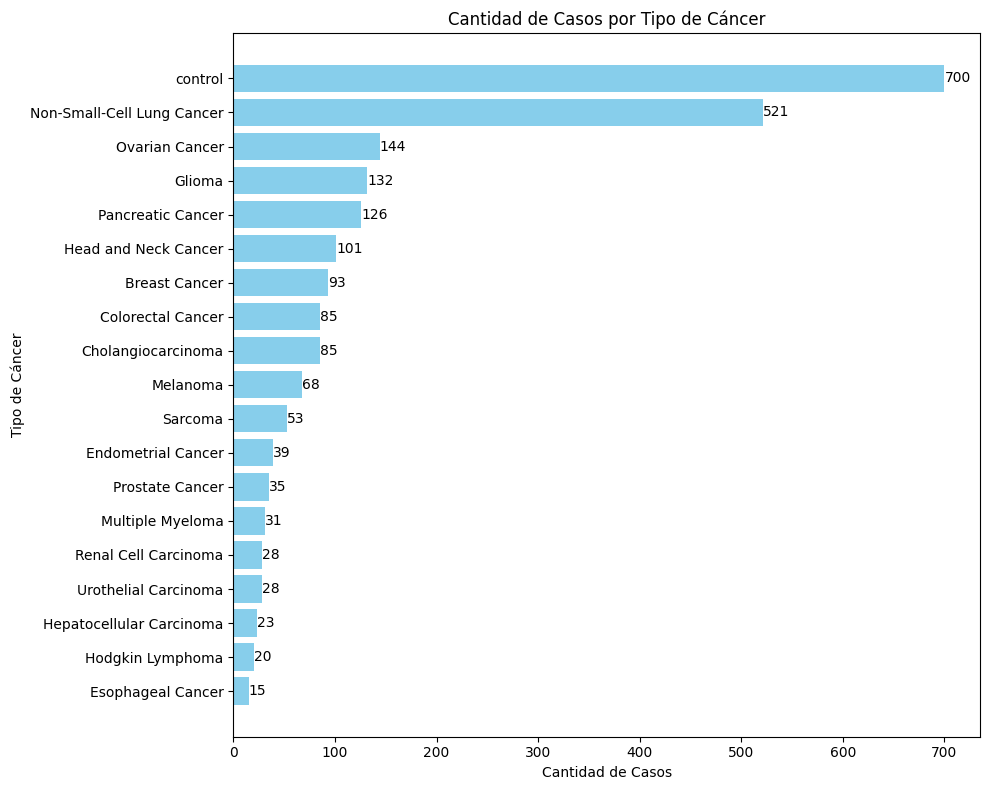

In [41]:
df_patient_group_counts = df_patient_group_counts.sort_values(by="Patient_group_counts", ascending=True)
plt.figure(figsize=(10, 8))
plt.barh(df_patient_group_counts["Patient_group"], df_patient_group_counts["Patient_group_counts"], color='skyblue')
plt.xlabel("Cantidad de Casos")
plt.ylabel("Tipo de Cáncer")
plt.title("Cantidad de Casos por Tipo de Cáncer")
for i, v in enumerate(df_patient_group_counts["Patient_group_counts"]):
    plt.text(v, i, str(v), ha='left', va='center')
plt.tight_layout()
plt.show()

In [42]:
#save dataframe
df_genes_labels_file = "Data/with_outliers/df_genes_labels.pkl"
if not os.path.exists(df_genes_labels_file):
    df_genes_labels.to_pickle(df_genes_labels_file)
else:
    df_genes_labels = pd.read_pickle(df_genes_labels_file)

In [43]:
#conteo_muestras = df_genes_labels.groupby(['Patient_group', 'Classification']).size()
muestras_no_malignas = df_genes_labels[df_genes_labels['Classification'] == 'nonMalignant']
conteo_muestras = muestras_no_malignas.groupby('Patient_group').size()
conteo_muestras

Patient_group
control                       700
Breast Cancer                   0
Cholangiocarcinoma              0
Colorectal Cancer               0
Endometrial Cancer              0
Esophageal Cancer               0
Glioma                          0
Head and Neck Cancer            0
Hepatocellular Carcinoma        0
Hodgkin Lymphoma                0
Melanoma                        0
Multiple Myeloma                0
Non-Small-Cell Lung Cancer      0
Ovarian Cancer                  0
Pancreatic Cancer               0
Prostate Cancer                 1
Renal Cell Carcinoma            0
Sarcoma                         0
Urothelial Carcinoma            0
dtype: int64

## Exploratory Analysis

In [44]:
#load dataframe
df_genes_labels_file = "Data/with_outliers/df_genes_labels.pkl"
if os.path.exists(df_genes_labels_file):
    df_genes_labels = pd.read_pickle(df_genes_labels_file)
else:
    raise Exception("You need to run the above cells")

column_gene_name = random.choice(df_genes_labels.columns.to_list())
print(f"Random column: {column_gene_name}")
fig = px.histogram(df_genes_labels, x=column_gene_name)
fig.show()

Random column: ENSG00000136104


In [45]:
fig = px.histogram(df_genes_labels, x=column_gene_name,  color="Classification", marginal="box")
fig.show()

In [46]:
import plotly.express as px
fig = px.histogram(df_genes_labels, x=column_gene_name,  color="Sex", marginal="box")
fig.show()

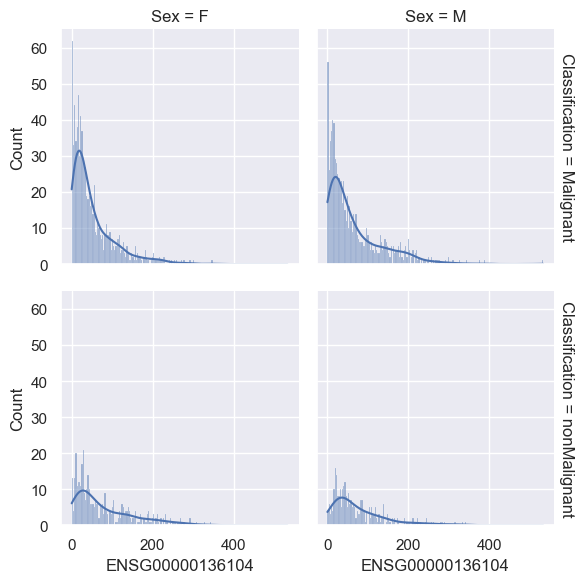

In [47]:
sns.set_theme(style="darkgrid")
graph = sns.displot(
    df_genes_labels, x=column_gene_name, col="Sex", row="Classification",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True), kde=True
)
plt.show()

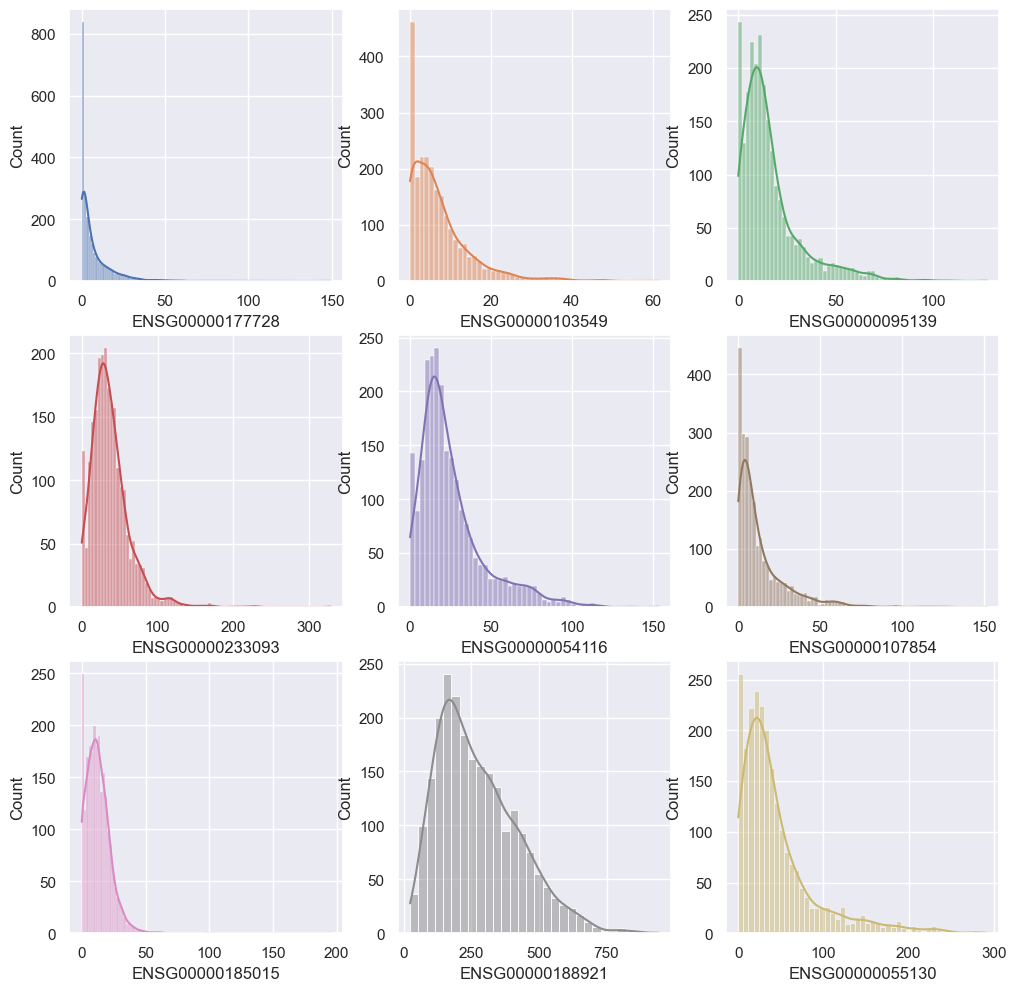

In [48]:
six_random_column = random.sample(df_genes_labels.columns.to_list(), 9)
sns.set(style="darkgrid")
palette = itertools.cycle(sns.color_palette())
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
sns.histplot(data=df_genes_labels, x=six_random_column[0], kde=True, color=next(palette), ax=axs[0, 0])
sns.histplot(data=df_genes_labels, x=six_random_column[1], kde=True, color=next(palette), ax=axs[0, 1])
sns.histplot(data=df_genes_labels, x=six_random_column[2], kde=True, color=next(palette), ax=axs[0, 2])
sns.histplot(data=df_genes_labels, x=six_random_column[3], kde=True, color=next(palette), ax=axs[1, 0])
sns.histplot(data=df_genes_labels, x=six_random_column[4], kde=True, color=next(palette), ax=axs[1, 1])
sns.histplot(data=df_genes_labels, x=six_random_column[5], kde=True, color=next(palette), ax=axs[1, 2])
sns.histplot(data=df_genes_labels, x=six_random_column[6], kde=True, color=next(palette), ax=axs[2, 0])
sns.histplot(data=df_genes_labels, x=six_random_column[7], kde=True, color=next(palette), ax=axs[2, 1])
sns.histplot(data=df_genes_labels, x=six_random_column[8], kde=True, color=next(palette), ax=axs[2, 2])
plt.show()

In [49]:
df_genes_labels.columns[:5440]

Index(['ENSG00000000419', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000001036', 'ENSG00000001461', 'ENSG00000001497',
       'ENSG00000001629', 'ENSG00000001631', 'ENSG00000002330',
       'ENSG00000002549',
       ...
       'ENSG00000267279', 'ENSG00000267316', 'ENSG00000268555',
       'ENSG00000269028', 'ENSG00000270055', 'ENSG00000271043',
       'ENSG00000272053', 'ENSG00000272168', 'ENSG00000272369',
       'ENSG00000272888'],
      dtype='object', length=5440)

In [50]:
# The Kolmogorov-Smirnov test tests the null hypothesis that the data was drawn from a normal distribution.
# It is similar in this case to the Shapiro Wilk test, but the main difference with it lies in the number of samples.
# While the Shapiro Wilk test can be used with up to 50 data, the Kolmogorov Smirnov test is recommended for more than 50 observations.

dist_norm_genes = []

for column in df_genes_labels.columns[:5440]:
    kstest_result = kstest(df_genes_labels[column], 'norm')
    if kstest_result.pvalue > .05:
        dist_norm_genes.append([column, kstest_result.statistic, kstest_result.pvalue])

print(f"Number of genes with pvalues greater than 0.05: {len(dist_norm_genes)}")

Number of genes with pvalues greater than 0.05: 0


#### As the above graphs show, most of the genes do not have a normal distribution. Therefore, to determine correlations between them we will use Spearman's method.

Reference: https://practicaldatascience.co.uk/data-science/how-to-calculate-spearmans-rank-correlation-in-pandas

In [51]:
df_genes_labels[['Classification', 'Patient_group', 'Center',
 'Source', 'Cell_type', 'Group', 'Stage', 'Sex']] = df_genes_labels[['Classification', 'Patient_group', 'Center',
  'Source', 'Cell_type', 'Group', 'Stage', 'Sex']].apply(lambda x: pd.factorize(x)[0])
df_genes_labels.iloc[:, 5440:].head(5)

,Classification,Patient_group,Center,Source,Cell_type,Group,Stage,Sex,Age
Vumc-HD-101-TR922,0,0,0,0,0,0,-1,0,35.0
Vumc-HD-103-TR923,0,0,0,1,0,0,-1,0,54.0
Vumc-HD-108-TR924,0,0,0,2,0,0,-1,0,56.0
Vumc-HD-127-TR925,0,0,0,3,0,0,-1,0,52.0
Vumc-HD-130-TR926,0,0,0,4,0,0,-1,0,57.0


In [52]:
#df_genes_class = df_genes_labels.iloc[:,:5441]
#df_genes_class.head(2)

In [53]:
def calc_corr_and_save (data_frame, corr_file_path, corr_method):
    spearman_path = corr_file_path
    if not os.path.exists(spearman_path):
        corr = data_frame.corr(method=corr_method, numeric_only = False, min_periods=1)
        corr.to_pickle(spearman_path)
    else:
        corr = pd.read_pickle(spearman_path)
    return corr

In [54]:
corr = calc_corr_and_save (df_genes_labels, "Data/spearman_corr.pkl", "spearman")

In [55]:
# Selecting the upper traingular.
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
# Selecting the columns which are having absolute correlation greater than 0.70
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]
print(len(to_drop))

1808


In [56]:
df_to_drop = corr.loc[to_drop][to_drop]
df_to_drop

,ENSG00000003756,ENSG00000004779,ENSG00000005022,ENSG00000005059,ENSG00000005249,ENSG00000005302,ENSG00000005844,ENSG00000005955,ENSG00000006015,ENSG00000007312,...,ENSG00000257923,ENSG00000260017,ENSG00000265148,ENSG00000266714,ENSG00000267316,ENSG00000269028,ENSG00000271043,Patient_group,Stage,Sex
ENSG00000003756,1.000000,0.671001,0.605531,0.714409,-0.381064,0.646673,0.737748,0.683719,0.597484,0.645965,...,-0.212152,0.082662,-0.300820,0.633576,-0.373310,-0.215920,-0.219560,-0.031025,-0.040773,0.060697
ENSG00000004779,0.671001,1.000000,0.588597,0.759460,-0.537223,0.691251,0.659242,0.731879,0.700537,0.685119,...,-0.428499,0.083285,-0.478443,0.655568,-0.332151,-0.083426,-0.086619,-0.099796,-0.101498,0.099305
ENSG00000005022,0.605531,0.588597,1.000000,0.663100,-0.384259,0.552133,0.636144,0.578607,0.481457,0.590821,...,-0.187555,0.022882,-0.274223,0.504426,-0.285157,-0.269575,-0.271743,-0.045020,-0.081054,0.098126
ENSG00000005059,0.714409,0.759460,0.663100,1.000000,-0.489838,0.711598,0.737155,0.743741,0.675698,0.736686,...,-0.334034,0.071453,-0.388649,0.673267,-0.331625,-0.168423,-0.168846,-0.107448,-0.103097,0.044446
ENSG00000005249,-0.381064,-0.537223,-0.384259,-0.489838,1.000000,-0.461859,-0.348691,-0.547476,-0.586993,-0.422485,...,0.640028,-0.245849,0.580117,-0.482655,0.280746,0.021876,0.038725,-0.075038,-0.091315,-0.018734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000269028,-0.215920,-0.083426,-0.269575,-0.168423,0.021876,-0.067161,-0.279828,-0.076656,-0.099053,-0.181227,...,-0.234534,-0.280643,-0.123248,-0.153931,0.238559,1.000000,0.961536,-0.134555,-0.077708,-0.008217
ENSG00000271043,-0.219560,-0.086619,-0.271743,-0.168846,0.038725,-0.072081,-0.276895,-0.084614,-0.099654,-0.181323,...,-0.225063,-0.275686,-0.118150,-0.157760,0.248113,0.961536,1.000000,-0.158977,-0.099018,-0.007486
Patient_group,-0.031025,-0.099796,-0.045020,-0.107448,-0.075038,-0.082489,-0.031228,-0.070911,-0.048727,-0.110041,...,0.144537,0.118461,0.115866,-0.043623,-0.208085,-0.134555,-0.158977,1.000000,0.682881,0.022637
Stage,-0.040773,-0.101498,-0.081054,-0.103097,-0.091315,-0.056224,-0.059970,-0.017728,-0.024374,-0.114642,...,0.075505,0.181865,0.070757,-0.017511,-0.145563,-0.077708,-0.099018,0.682881,1.000000,-0.026322


In [57]:
to_drop = [x for x in to_drop if x not in ["Patient_group", "Stage", "Sex"]]
len(to_drop)

1805

In [58]:
#plt.figure(figsize=(14,8))
#sns.heatmap(df_to_drop.loc[df_to_drop.index.to_list(), df_to_drop.index.to_list()], annot=True, cmap='Blues')
#plt.show()

In [59]:
# droping the columns which are in the list 'to_drop' from the dataframe upper_tri
df_genes_labels_clean = df_genes_labels.drop(to_drop, axis=1, inplace=False)
print(df_genes_labels_clean.shape)

(2327, 3644)


In [60]:
corr_class = corr["Classification"].sort_values(ascending=False)
corr_class

Classification     1.000000
Patient_group      0.808553
Stage              0.713884
Age                0.338399
ENSG00000185825    0.338086
                     ...   
ENSG00000227165   -0.310520
ENSG00000240225   -0.322707
ENSG00000111196   -0.331347
Center                  NaN
Cell_type               NaN
Name: Classification, Length: 5449, dtype: float64

In [61]:
threshold_p_value = .3
corr_class = corr_class.loc[(corr_class > threshold_p_value) | (corr_class < threshold_p_value * -1)]
print(len(corr_class))
corr_class

15


Classification     1.000000
Patient_group      0.808553
Stage              0.713884
Age                0.338399
ENSG00000185825    0.338086
ENSG00000172757    0.329584
ENSG00000142089    0.315600
ENSG00000213465    0.315487
ENSG00000102265    0.301901
ENSG00000005961    0.301214
ENSG00000103512   -0.306192
ENSG00000130948   -0.308532
ENSG00000227165   -0.310520
ENSG00000240225   -0.322707
ENSG00000111196   -0.331347
Name: Classification, dtype: float64

In [62]:
corr_group = corr["Patient_group"].sort_values(ascending=False)
corr_group

Patient_group      1.000000
Classification     0.808553
Stage              0.682881
Group              0.430152
Age                0.321843
                     ...   
ENSG00000111196   -0.258029
ENSG00000177410   -0.266458
ENSG00000130948   -0.266570
Center                  NaN
Cell_type               NaN
Name: Patient_group, Length: 5449, dtype: float64

In [63]:
corr_group = corr_group.loc[(corr_group > threshold_p_value) | (corr_group < threshold_p_value * -1)]
print(len(corr_group))
corr_group

5


Patient_group     1.000000
Classification    0.808553
Stage             0.682881
Group             0.430152
Age               0.321843
Name: Patient_group, dtype: float64

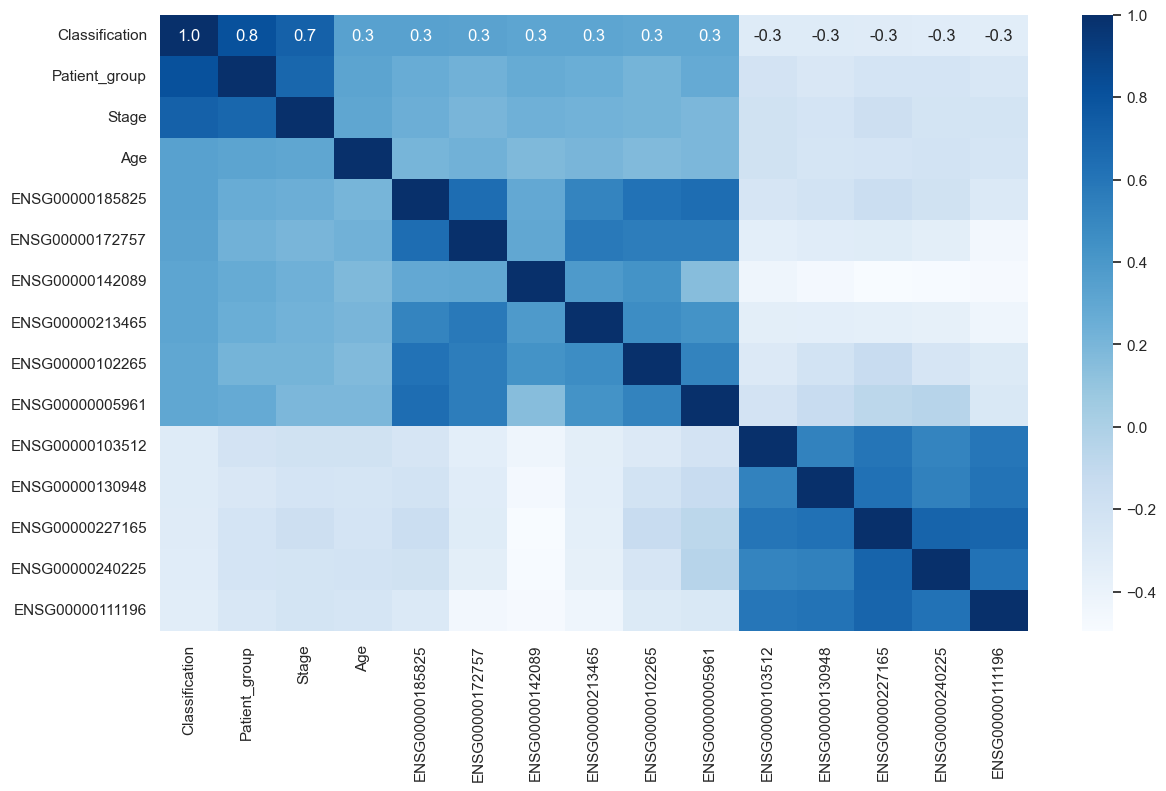

In [64]:
# Heatmaps with the 13 (over .3 in spearman p_value) variables correlated with classification
plt.figure(figsize=(14,8))
sns.heatmap(corr.loc[corr_class.index.to_list(), corr_class.index.to_list()], annot=True, fmt=".1f", cmap='Blues')
plt.show()

In [65]:
#Remove Nan values
df_genes_labels_clean.isna().sum()

ENSG00000000419     0
ENSG00000000460     0
ENSG00000000938     0
ENSG00000001036     0
ENSG00000001461     0
                   ..
Cell_type           0
Group               0
Stage               0
Sex                 0
Age                23
Length: 3644, dtype: int64

In [66]:
df_genes_labels_tmp = df_genes_labels_clean.drop(['Classification',	'Patient_group', 'Center', 'Source', 'Cell_type', 'Group',	'Stage', 'Sex', 'Age'], axis=1)
df_genes_labels_tmp.isna().sum().sum()

0

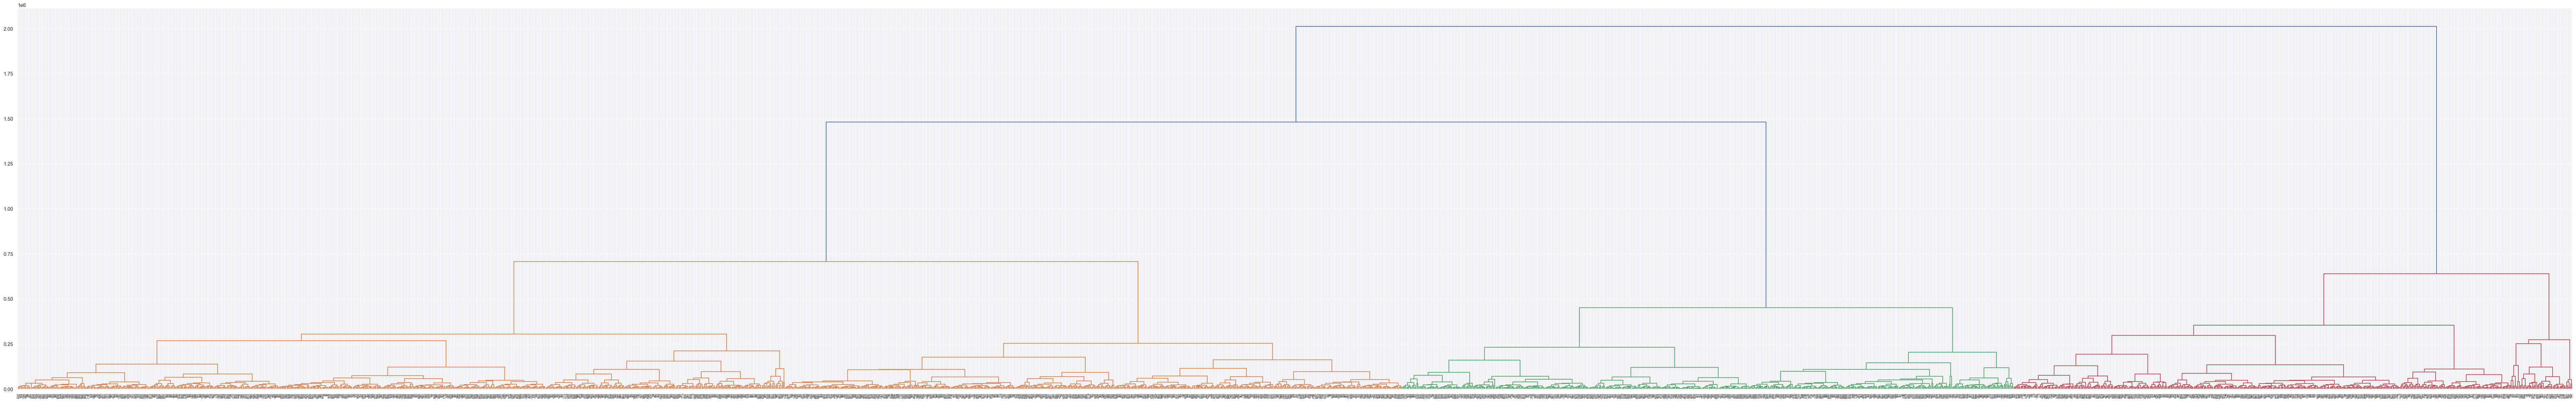

In [67]:
linked = linkage(df_genes_labels_tmp, 'ward')
plt.figure(figsize=(100, 15))
dendrogram(linked,
            orientation='top',
            #labels=target,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [68]:
#df_genes_labels_tmp.T.columns.to_list()
#sns_plot = sns.clustermap(df_genes_labels_tmp.T, xticklabels=df_genes_labels_tmp.T.columns.to_list(), yticklabels= df_genes_labels_tmp.T.index.to_list())
#sns_plot.show()

## DBSCAN analysis

References:  
https://ideasbyjin.github.io/post/2019-12-18-clustering-2/   
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc


In [69]:
#Check tha range of the TPM values
#df_genes_labels_t = df_genes_labels.T
vals = df_genes_labels_clean[df_genes_labels_clean.columns[:df_genes_labels_clean.shape[1]-9]].astype(float).values
vals

array([[  4.09505663,   1.74127368,   8.33003273, ...,  10.77954796,
         61.4332114 ,  26.59938027],
       [ 76.1705101 ,   2.56239992, 137.29180289, ...,   4.97657133,
        102.24897006,  39.45589764],
       [ 92.72547237,   8.92231384, 226.2888137 , ...,   4.53841505,
         99.24248155,  37.38394833],
       ...,
       [ 46.83442887,  87.12652815, 359.46439631, ...,   0.        ,
         26.91956436,  30.42123455],
       [116.90001816,   5.82509471, 278.66515283, ...,   1.88553701,
         18.8977417 ,  28.47458823],
       [  0.        ,   3.00010742,  66.97662491, ...,  29.13333012,
         58.39759655,  36.66327662]])

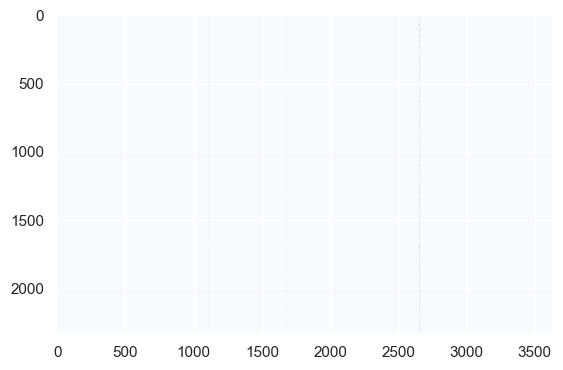

In [70]:
# Let's plot a heatmap first, as it's a matrix
plt.imshow(vals, interpolation='nearest', cmap = 'Blues')

Min: 0.0, Max: 292405.29118422425, Mean: 120.82551077469381, Median: 16.9629366450824


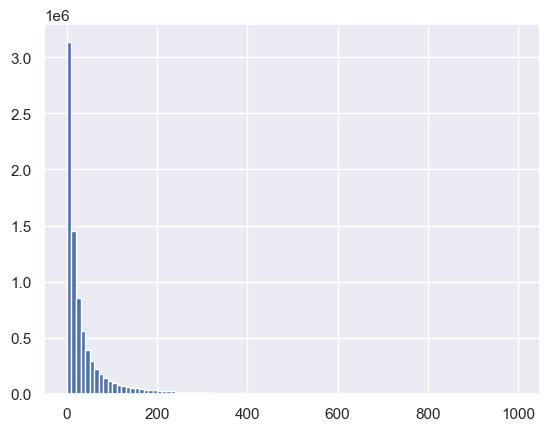

In [71]:
# Flatten to a 1-dimensional vector.
valarray = vals.flatten()

min_tpm = np.min(valarray)
max_tpm = np.max(valarray)
mean_tpm = np.mean(valarray)
median_tpm = np.median(valarray)

# Draw the histogram
o = plt.hist(valarray, bins = np.arange(0, 1001, 10))

print("Min: {}, Max: {}, Mean: {}, Median: {}".format(min_tpm, max_tpm, mean_tpm, median_tpm))

Min: 0.0, Max: 12.585899522304222, Mean: 2.877518066165654, Median: 2.8883105598129566


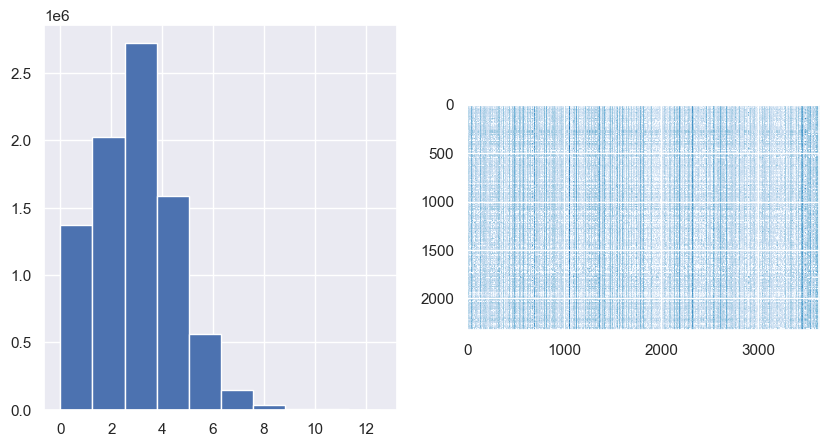

In [72]:
logTpm = np.log(vals+1)

logTpmArray = logTpm.flatten()

min_tpm = np.min(logTpmArray)
max_tpm = np.max(logTpmArray)
mean_tpm = np.mean(logTpmArray)
median_tpm = np.median(logTpmArray)
print("Min: {}, Max: {}, Mean: {}, Median: {}".format(min_tpm, max_tpm, mean_tpm, median_tpm))

fig, ax = plt.subplots(1,2)
ax[0].hist(logTpmArray)
ax[1].imshow(logTpm, interpolation='nearest', cmap = 'Blues')

fig.set_size_inches((10,5))

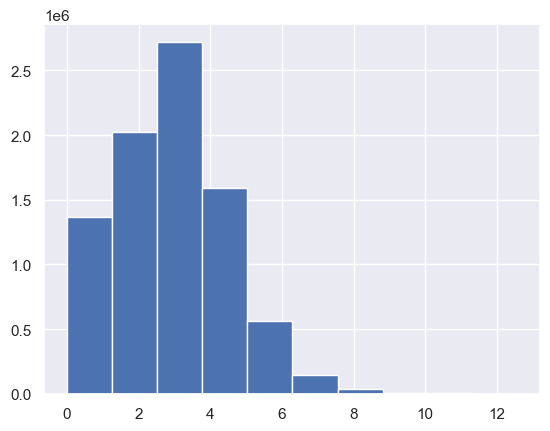

In [73]:
o = plt.hist(logTpmArray)

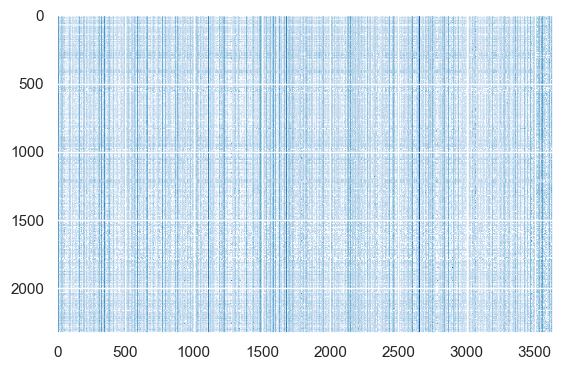

In [74]:
plt.imshow(logTpm, interpolation='nearest', cmap = 'Blues')

In [75]:
# pairwise distances - use default of Euclidean though there are various ways of doing this
# This will take a while since there's ~3000 pairwise distances to compute.
dmat = pdist(logTpm)

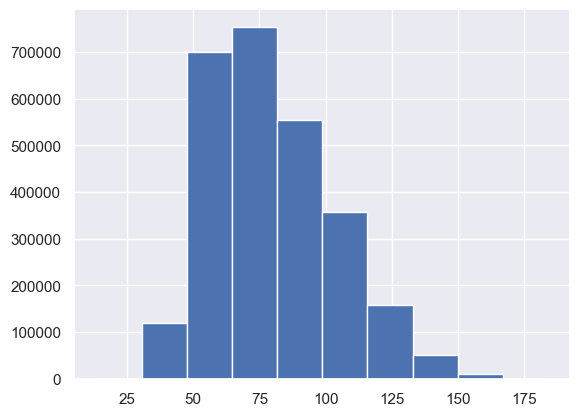

In [76]:
# Let's look at the distribution of distances
o = plt.hist(dmat)

In [77]:
# Convert distance matrix from pdist into a square matrix
sqmat = squareform(dmat)

In [78]:
# Initialise an MDS object, this allows us to visualise points in space
mds = MDS(dissimilarity='precomputed')

In [79]:
# This step can take a while
mds_coords_path = 'Data/mds_coords.npy'
if not os.path.exists(mds_coords_path):
    np.random.seed(0)
    coords = mds.fit_transform(sqmat)
    np.save(mds_coords_path, coords)
else:
    coords = np.load(mds_coords_path)

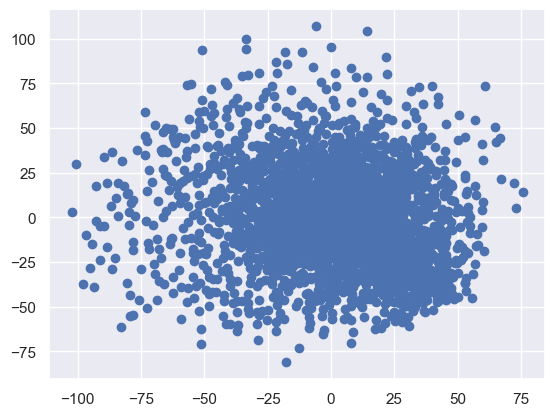

In [80]:
plt.scatter(coords[:,0], coords[:,1])
plt.show()

In [81]:
def fit_dbscan(metric, eps, min_samples):
    dbscan = DBSCAN(metric=metric, eps = eps, min_samples = min_samples)
    dbscan.fit(sqmat)

    print(dbscan.labels_.shape)

    print(set(dbscan.labels_))

    unique, counts = np.unique(dbscan.labels_, return_counts=True)
    print( dict(zip(unique, counts)) )
    return dbscan

In [82]:
THRESHOLD = 70
min_samples = 4
dbscan = fit_dbscan('precomputed', THRESHOLD, min_samples)

(2327,)
{0, -1}
{-1: 272, 0: 2055}


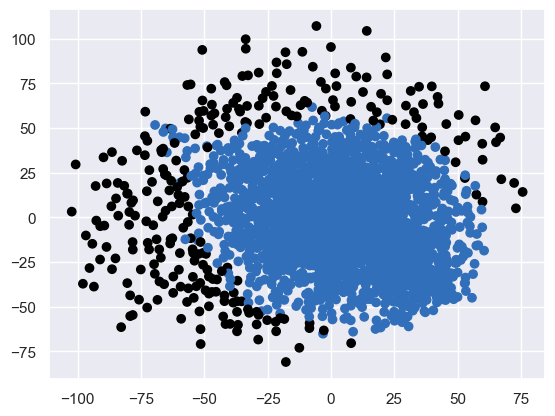

In [83]:
# Colour points based on cluster membership
cols = {0: '#316fba', -1:'black'}
colours = [ cols[c] for c in dbscan.labels_ ]

# Now let's see what the clusters look like
plt.scatter(coords[:,0], coords[:,1], c = colours)
plt.show()

In [84]:
sample_ids_used = df_genes_labels_clean.index
sample_id_to_smts = df_genes_labels['Classification']
class_represented = {0: set(), -1: set()}

for i, label in enumerate(dbscan.labels_):        
    sample_id = sample_ids_used[i]
    class_sample = sample_id_to_smts[sample_id]
    
    class_represented[label].add(class_sample)

In [85]:
class_represented

{0: {0, 1}, -1: {0, 1}}

Run algoritm OPTICS to evaluate compare clusters with DBSCAN

In [86]:
def fit_optics(min_samples, xi, min_cluster_size):
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    optics.fit(sqmat)
    print(optics.labels_.shape)
    print(set(optics.labels_))
    unique, counts = np.unique(optics.labels_, return_counts=True)
    print( dict(zip(unique, counts)) )
    return optics

In [392]:
min_samples = 4
optics = fit_optics(min_samples=min_samples, xi=0.085, min_cluster_size=0.005)

(2327,)
{0}
{0: 2327}


In [ ]:
# Colour points based on cluster membership
cols = {0: '#316fba', -1:'black'}
colours = [ cols[c] for c in optics.labels_ ]

# Now let's see what the clusters look like
plt.scatter(coords[:,0], coords[:,1], c = colours)
plt.show()

#### Reduces the dimension of the input features (genes). Data without outliers.

In [87]:
# Remove outliers
outliers_index = np.where(dbscan.labels_ == -1)[0]
print(len(outliers_index))
df_genes_labels_clean = df_genes_labels_clean.drop(df_genes_labels_clean.columns[outliers_index], axis=1)

272


In [88]:
df_genes_labels_clean.shape

(2327, 3372)

## TSNE analysis

In [102]:
expression_data = df_genes_labels_clean.iloc[:, :df_genes_labels_clean.shape[1]-9]
labels = df_genes_labels_clean["Classification"]
class_name = {0: "No maligno", 1: "Maligno"}
labels = labels.replace(class_name)
labels

Vumc-HD-101-TR922       No maligno
Vumc-HD-103-TR923       No maligno
Vumc-HD-108-TR924       No maligno
Vumc-HD-127-TR925       No maligno
Vumc-HD-130-TR926       No maligno
                           ...    
NKI-4941-SARC-TR3084    No maligno
NKI-6348-SARC-TR3134    No maligno
NKI-5275-SARC-TR3099    No maligno
NKI-5148-SARC-TR3129    No maligno
P-PH-001-013-TR1400     No maligno
Name: Classification, Length: 2327, dtype: object

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2327 samples in 0.098s...
[t-SNE] Computed neighbors for 2327 samples in 0.558s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2327
[t-SNE] Computed conditional probabilities for sample 2000 / 2327
[t-SNE] Computed conditional probabilities for sample 2327 / 2327
[t-SNE] Mean sigma: 5371.075835
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.403900
[t-SNE] KL divergence after 4000 iterations: 1.103371


[Text(0.5, 1.0, 'tSNE')]

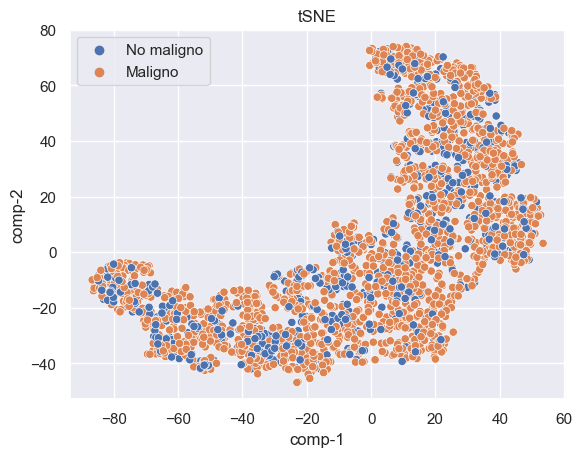

In [117]:
expression_data = df_genes_labels_clean.iloc[:, :df_genes_labels_clean.shape[1]-9]
labels = df_genes_labels_clean["Classification"]
class_name = {0: "No maligno", 1: "Maligno"}
labels = labels.replace(class_name)

tsne = TSNE(n_components=2, verbose=1, random_state=42, learning_rate='auto', init='random', n_iter=4000)
z = tsne.fit_transform(expression_data)

df_z = pd.DataFrame()
df_z["y"] = labels
df_z["comp-1"] = z[:,0]
df_z["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_z.y.tolist(),
                palette=sns.color_palette("deep", 2),
                data=df_z).set(title="tSNE") 

## PCA analysis

<Axes: >

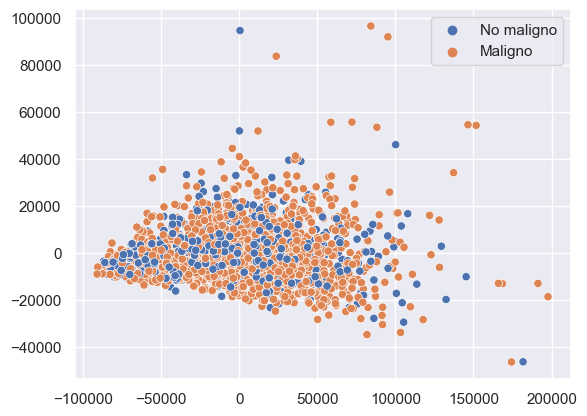

In [120]:
expression_data = df_genes_labels_clean.iloc[:, :df_genes_labels_clean.shape[1]-9]
labels = df_genes_labels_clean["Classification"]
class_name = {0: "No maligno", 1: "Maligno"}
labels = labels.replace(class_name)
pca = PCA(n_components=2, random_state=42)
z = pca.fit_transform(expression_data)

sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=labels.tolist(), palette=sns.color_palette("deep", 2))

In [123]:
# Find potential outliers
threshold = 130000
index_outliers = [i for i,v in enumerate(z) if v[0] > threshold]
print(index_outliers)
print(len(index_outliers))

print(labels.iloc[index_outliers[0]])
print(labels.iloc[index_outliers[1]])

[31, 76, 347, 813, 818, 829, 946, 1117, 1449, 1950, 1961]
11
0
0


<Axes: >

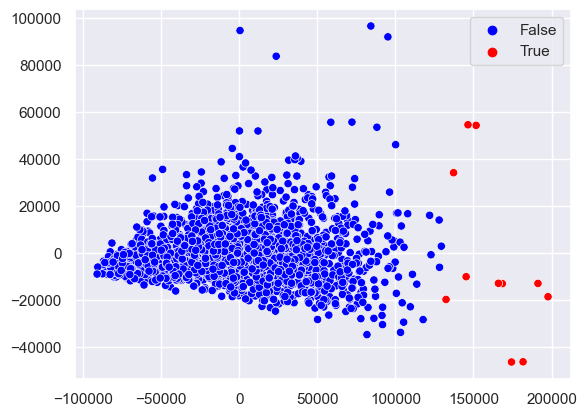

In [124]:
expression_data = df_genes_labels_clean.iloc[:, :df_genes_labels_clean.shape[1]-9]
labels = df_genes_labels_clean["Classification"]
pca = PCA(n_components=2, random_state=42)
z = pca.fit_transform(expression_data)

threshold = 130000
outliers = (np.abs(z[:, 0]) > threshold) | (np.abs(z[:, 1]) > threshold)
sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=outliers, palette={True: 'red', False: 'blue'})



In [125]:
df_genes_labels_clean.shape

(2327, 3372)

In [126]:
outliers_indexes = df_genes_labels_clean.index[outliers]
outlier_classifications = df_genes_labels_clean['Classification'][outliers]
outlier_classifications

AMC-HD-003-TR1141         0
Vumc-HD-150-TR1133        0
Vumc-NSCLC-130-TR952      1
Vumc-ORC-01-024-TR2362    1
Vumc-ORC-01-032-TR2369    1
Vumc-ORC-01-030-TR2367    1
Vumc-EPI-016-TR1436       0
TR4593-VUMC-HN            1
NKI-NSCLC-1593-TR1845     1
Vumc-PDAC-21-TR1011       1
Vumc-PDAC-50-TR989        1
Name: Classification, dtype: int64

In [127]:
# Remove outliers
df_genes_labels_clean_1 = df_genes_labels_clean.drop(outliers_indexes)

In [128]:
df_genes_labels_clean_1.shape

(2316, 3372)

## SAVE DATA

In [129]:
#save dataframe
df_genes_labels_file = "Data/without_outliers/df_genes_labels_without_outliers.pkl"
if not os.path.exists(df_genes_labels_file):
    df_genes_labels_clean.to_pickle(df_genes_labels_file)

In [130]:
df_genes_labels_clean[["Classification", "Patient_group"]].groupby("Patient_group").agg( {
        "Classification": ["value_counts"]
    })

,,Classification
,,value_counts
Patient_group,Classification,
0,0,700
1,1,132
2,1,521
3,1,126
4,1,93
5,1,101
6,1,68
7,1,144


In [131]:
df_genes_labels_clean.head(2)

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000272888,Classification,Patient_group,Center,Source,Cell_type,Group,Stage,Sex,Age
Vumc-HD-101-TR922,4.095057,1.741274,8.330033,15.249858,12.412785,1.815643,6.687894,5.566237,41.660991,28.708953,...,26.599380,0,0,0,0,0,0,-1,0,35.0
Vumc-HD-103-TR923,76.170510,2.562400,137.291803,21.732511,3.450289,8.549888,3.662021,21.998922,39.428762,51.453223,...,39.455898,0,0,0,1,0,0,-1,0,54.0


In [132]:
df_labels_subfix = df_labels.add_suffix('_1')
df_patien_groups_named = pd.concat([df_genes_labels_clean, df_labels_subfix[['Patient_group_1']]], axis=1)
df_patien_groups_named.head(2)

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,Classification,Patient_group,Center,Source,Cell_type,Group,Stage,Sex,Age,Patient_group_1
Vumc-HD-101-TR922,4.095057,1.741274,8.330033,15.249858,12.412785,1.815643,6.687894,5.566237,41.660991,28.708953,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,35.0,Asymptomatic Controls
Vumc-HD-103-TR923,76.170510,2.562400,137.291803,21.732511,3.450289,8.549888,3.662021,21.998922,39.428762,51.453223,...,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,54.0,Asymptomatic Controls


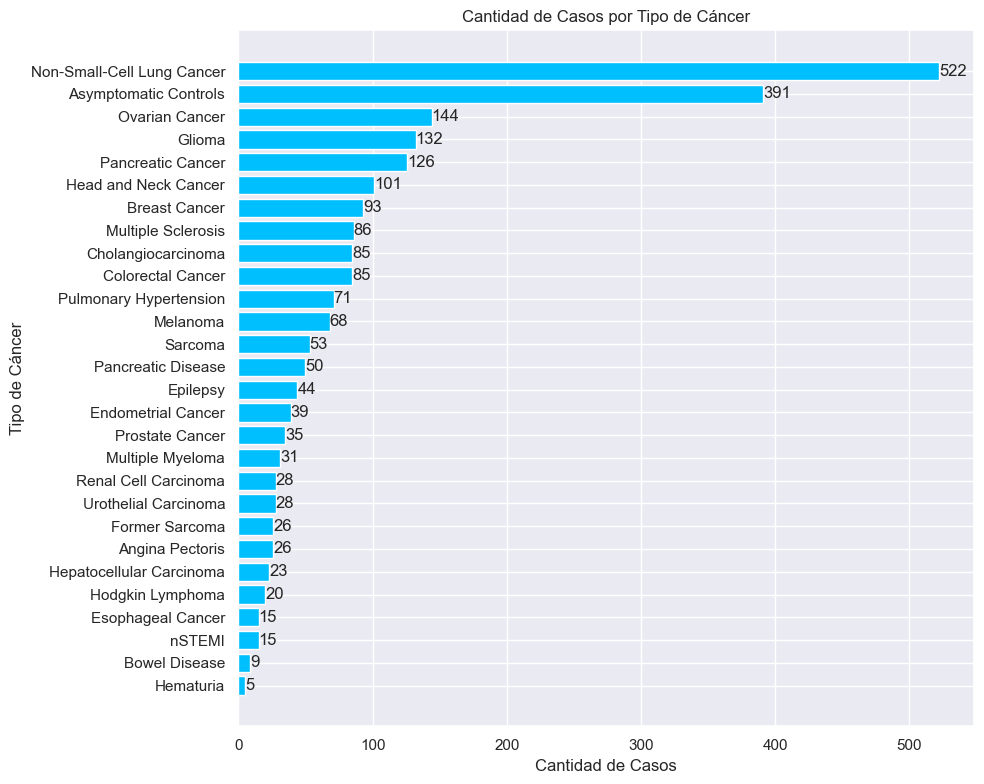

In [133]:
df_labels_subfix = df_labels.add_suffix('_1')
df_patien_groups_named = pd.concat([df_genes_labels_clean, df_labels_subfix[['Patient_group_1']]], axis=1)
df_patient_group_counts = df_patien_groups_named['Patient_group_1'].value_counts().reset_index()
df_patient_group_counts.columns = ['Patient_group_1', 'Patient_group_counts']
df_patient_group_counts = df_patient_group_counts.sort_values(by="Patient_group_counts", ascending=True)
plt.figure(figsize=(10, 8))
plt.barh(df_patient_group_counts["Patient_group_1"], df_patient_group_counts["Patient_group_counts"], color='deepskyblue')
plt.xlabel("Cantidad de Casos")
plt.ylabel("Tipo de Cáncer")
plt.title("Cantidad de Casos por Tipo de Cáncer")
for i, v in enumerate(df_patient_group_counts["Patient_group_counts"]):
    plt.text(v, i, str(v), ha='left', va='center')
plt.tight_layout()
plt.show()

In [134]:
# Select feature without outliers

gene_expression = df_genes_labels_clean.iloc[:, :df_genes_labels_clean.shape[1]-8]
gene_expression = np.asarray(gene_expression.values)
class_labels = df_genes_labels_clean.iloc[:, df_genes_labels_clean.shape[1]-9:df_genes_labels_clean.shape[1]-8].to_numpy().flatten()
#splitting the data into train-test
X_train, X_test, y_train, y_test = train_test_split(gene_expression, class_labels, test_size=0.40, random_state=42, stratify=class_labels)

In [ ]:
#filter technique (Mutual Information [MI])
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', n_neighbors=3, copy=True, random_state=42)

In [98]:
# Remove zero values
gains = np.asarray(mi)
indexes = np.where(gains != 0)[0]
print(len(indexes))
gains.shape

1504


(2204,)

In [99]:
# Estimate best hyperparams to SVC
# defining parameter range
param_grid = {'C': [1, 10, 100], 'tol': [0.1, 0.01, 0.001, 0.0001],
               'dual':['auto'],  'class_weight': ('balanced', 'None')}   
grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 1, scoring='roc_auc')

it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-100:]
X_train, X_test, y_train, y_test = train_test_split(gene_expression, class_labels, test_size=0.40, random_state=42, stratify=class_labels)
x_train = X_train[:, it]
Y_train = y_train[:]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    grid.fit(x_train, Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [100]:
# print best score
print(grid.best_score_)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

1.0
{'C': 1, 'class_weight': 'balanced', 'dual': 'auto', 'tol': 0.0001}
LinearSVC(C=1, class_weight='balanced', dual='auto')


In [101]:
def get_svc_model():
    return LinearSVC(random_state=42, dual=True, C=1000, tol=0.00001, class_weight='balanced')

In [102]:
def split_df():
    X_train, X_test, y_train, y_test = train_test_split(gene_expression, class_labels, test_size=0.40, random_state=42, stratify=class_labels)
    return X_train, X_test, y_train, y_test

In [ ]:
# Traingin a linearSVC model with different numbers of MI features starting from the top 2 to the top 1000
# the highest accuracy corresponds to the best number of features
graph_MI = []
X_train, X_test, y_train, y_test = split_df()

TotalTime = time.time()
for i in range (2,500):  
    it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-i:]
    x_train = X_train[:, it]
    x_test = X_test[:, it]
    Y_train = y_train[:]
    Y_test = y_test[:]
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    clf = get_svc_model()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        clf.fit(x_train, Y_train)
    scores = clf.score(x_test, Y_test)
    endTime = time.time()
    y_pred = clf.predict(x_test)
    graph_MI.append(scores)
EndTime = time.time()
print('TotalTime: ' + str(EndTime - TotalTime))

Text(0, 0.5, 'Accuracy')

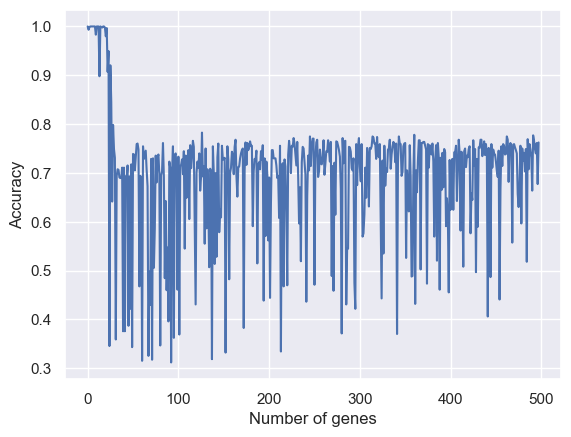

In [ ]:
#Plot a graph with all accuracy scores
plt.plot(graph_MI)
plt.xlabel('Number of genes')
plt.ylabel('Accuracy')

In [ ]:
#Display the best number of features
graph_MI = np.asarray(graph_MI)
print(np.argmax(graph_MI))
print(graph_MI[np.argmax(graph_MI)]) 
print(np.where(graph_MI == graph_MI[np.argmax(graph_MI)]))

#Since the counting started from 2 in the for loop, 2 should be added to those numbers
#In other words, the least number of features that can generate top accuracy is 19 not 17

0
1.0
(array([ 0,  3,  4,  5,  6,  7,  8, 10, 11, 12, 14, 17, 18], dtype=int64),)
